In [1]:
import sys
sys.path.insert(0,'../')

In [2]:
import pandas as pd
import numpy as np
import helper
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
d_train = pd.read_csv('train.csv')
d_test = pd.read_csv('test.csv')

In [4]:
d_train.shape,d_test.shape

((1460, 81), (1459, 80))

In [5]:
d_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
all_inp_features= d_train.columns
model_features=set()
features_with_outliers=set()

In [7]:
for df in [d_train,d_test]:
    d_na_ = helper.find_na(df)
    print(d_na_)

         feature  NaN Count  % out of total population
0    LotFrontage        259                      17.74
1          Alley       1369                      93.77
2     MasVnrType          8                       0.55
3     MasVnrArea          8                       0.55
4       BsmtQual         37                       2.53
5       BsmtCond         37                       2.53
6   BsmtExposure         38                       2.60
7   BsmtFinType1         37                       2.53
8   BsmtFinType2         38                       2.60
9    FireplaceQu        690                      47.26
10    GarageType         81                       5.55
11   GarageYrBlt         81                       5.55
12  GarageFinish         81                       5.55
13    GarageQual         81                       5.55
14    GarageCond         81                       5.55
15        PoolQC       1453                      99.52
16         Fence       1179                      80.75
17   MiscF

In [8]:
d_train.Alley.unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [9]:
for df in [d_train,d_test]:
    df.Alley.fillna('No Alley',inplace=True)
    helper.replace_classes(df,["Alley"],[{"No Alley":0,"Grvl":1,"Pave":2}])
    
d_train[["Alley","SalePrice"]].corr()
#sns.barplot(x="Alley",y="SalePrice",data=d_train)
##inference: there doesn't seem to be much correlation between Alley and Saleprice
#so droping Alley for now, and revisit during model optimization
helper.drop_col_inplace([d_train,d_test],["Alley"])

In [10]:
print(d_train.loc[d_train.PoolQC.isna()==False].shape[0],d_test.loc[d_test.PoolQC.isna()==False].shape[0])
#sns.barplot(x="PoolQC",y="SalePrice",hue="PoolQC",data=d_train)
##almost 100%(~99.7%) of PoolQC data population is missing, so better to drop for now, if needed revisit during model optimization
helper.drop_col_inplace([d_train,d_test],["PoolQC"])

7 3


In [11]:
for df in [d_train,d_test]:
    df.MiscFeature.fillna('None',inplace=True)
    helper.replace_classes(df,["MiscFeature"],[{"Elev":0,"Gar2":1,"Othr":2,"Shed":3,"TenC":4,"None":5}])
    
d_train[["MiscFeature","SalePrice"]].corr()
##most of PooMiscFeature data in population is missing,and there is around 9% correlation with saleprice
#so better to drop for now, if needed revisit during model optimization

,MiscFeature,SalePrice
MiscFeature,1.000000,0.073609
SalePrice,0.073609,1.000000


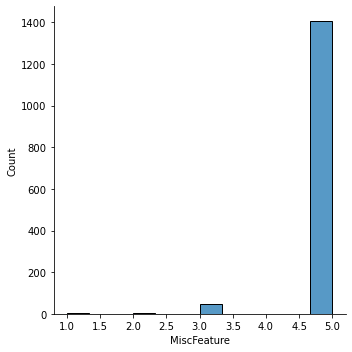

In [12]:
#MiscFeature -mssing data
d_train.MiscFeature.unique()
sns.displot(d_train.MiscFeature)
#sns.catplot(x="MSSubClass",y="SalePrice",hue="MiscFeature",data=d_train)
#sns.boxplot(x="MiscFeature",y="SalePrice",hue="MiscFeature",data=d_train)

In [13]:
helper.drop_col_inplace([d_train,d_test],["MiscFeature"])

In [14]:
#Fence -missing data
d_train.Fence.unique()
for df in [d_train,d_test]:
    df.Fence.fillna('None',inplace=True)
    helper.replace_classes(df,["Fence"],[{"GdPrv":0,"MnPrv":1,"GdWo":2,"MnWw":3,"None":4}])
    
d_train[["Fence","SalePrice"]].corr()
## there seem to be good amount of correlation(~15%) between fence and saleprice, hence consider this feature
model_features.add("Fence")

<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

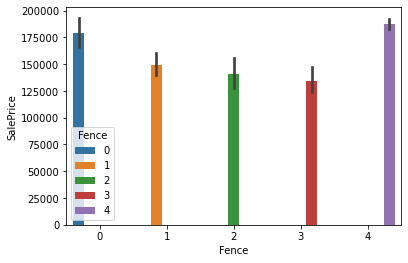

In [15]:
#sns.displot(d_train.Fence)
#sns.catplot(x="MSSubClass",y="SalePrice",hue="MiscFeature",data=d_train)
sns.barplot(x="Fence",y="SalePrice",hue="Fence",data=d_train)

In [16]:
#FireplaceQu -missing data
d_train.FireplaceQu.unique()
for df in [d_train,d_test]:
    df.FireplaceQu.fillna('None',inplace=True)
    helper.replace_classes(df,["FireplaceQu"],[{"Ex":0,"Gd":1,"TA":2,"Fa":3,"Po":4,"None":5}])
d_train[["FireplaceQu","SalePrice"]].corr()
## there seem to be good amount of correlation(~52% in negative direction) between fence and saleprice, hence consider this feature


,FireplaceQu,SalePrice
FireplaceQu,1.000000,-0.520438
SalePrice,-0.520438,1.000000


In [17]:
model_features.add("FireplaceQu")    

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

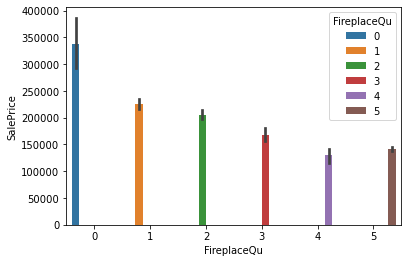

In [18]:
sns.barplot(x="FireplaceQu",y="SalePrice",hue="FireplaceQu",data=d_train)
#as trend(saleprice) seems to go down as the FireplaceQu (ordinal category) goes down the order
#we can confirm the same with corrleation between FireplaceQu & Saleprice above

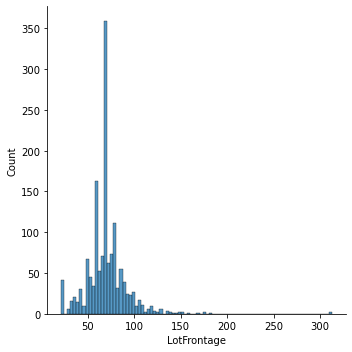

In [19]:
#LotFrontage -missing data

#d_train[["LotFrontage","LotArea"]].corr()
## there is high positive correlation between LotFrontage & LotArea. but between these two LotFrontage carries more info in 
#predicting SalePrice - this can be found again in the corelation

#lot frontage distribution looks bit of right skewed, and we will fill na with median value
for df in [d_train,d_test]:
    df.LotFrontage.fillna(df.LotFrontage.median(),inplace=True)

#sns.boxplot(x="LotFrontage",data=d_train)
##TODO:need to handle outliers
sns.displot(x="LotFrontage",data=d_train)

In [20]:
d_train[["LotFrontage","SalePrice"]].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.334771
SalePrice,0.334771,1.000000


In [21]:
model_features.add("LotFrontage")

In [22]:
model_features

{'Fence', 'FireplaceQu', 'LotFrontage'}

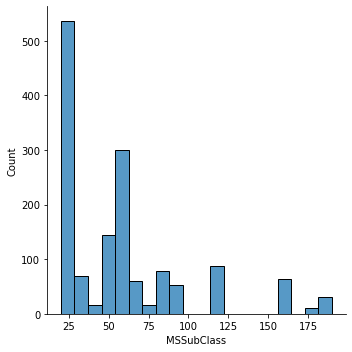

In [23]:
sns.displot(d_train.MSSubClass)

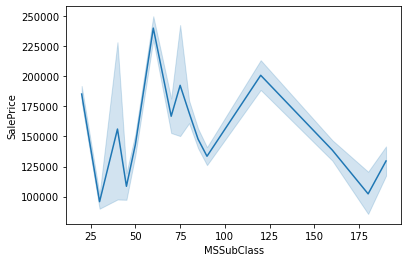

In [24]:
sns.lineplot(x="MSSubClass",y="SalePrice",data=d_train)
#1. with the help of below line plot, it shows a clear indication that prices varies for different classes
#2.analysis on heatmap shows MSSubClass isn't correlated with any other feature - considering this is a good option
model_features.add('MSSubClass')

In [25]:
model_features

{'Fence', 'FireplaceQu', 'LotFrontage', 'MSSubClass'}

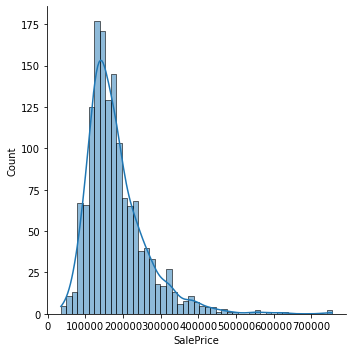

In [26]:
sns.displot(d_train.SalePrice,kde=True) #right skewed

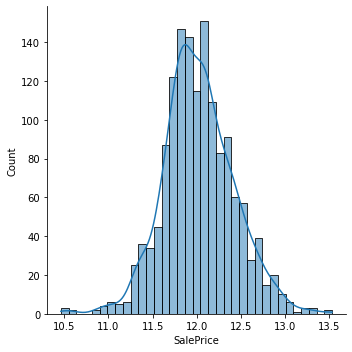

In [27]:
##log transform - found this in one of the kaggle eda notebooks
sns.displot(np.log(d_train.SalePrice),kde=True)

In [28]:
catg_ft= ["MSZoning","Street","LotShape","LandContour","Utilities","LotConfig","LandSlope","Neighborhood","Condition1","Condition2"
          ,"BldgType","HouseStyle","OverallQual","OverallCond","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","ExterQual",
         "ExterCond","Foundation","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","Heating","HeatingQC","CentralAir"
          ,"Electrical","KitchenQual","Functional","GarageType","GarageFinish","GarageQual","GarageCond","PavedDrive","SaleType","SaleCondition"]


In [29]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
for df in [d_train,d_test]:
    for x in catg_ft:
        df[x]= enc.fit_transform(df[x])

In [30]:
d_train[["GarageArea","SalePrice"]].corr()

,GarageArea,SalePrice
GarageArea,1.000000,0.623431
SalePrice,0.623431,1.000000


In [31]:
cols = d_test.columns
for df in [d_train,d_test]:
    for x in cols:
        if df[x].isna().sum()>0:
            df[x].fillna(df[x].median(),inplace=True)

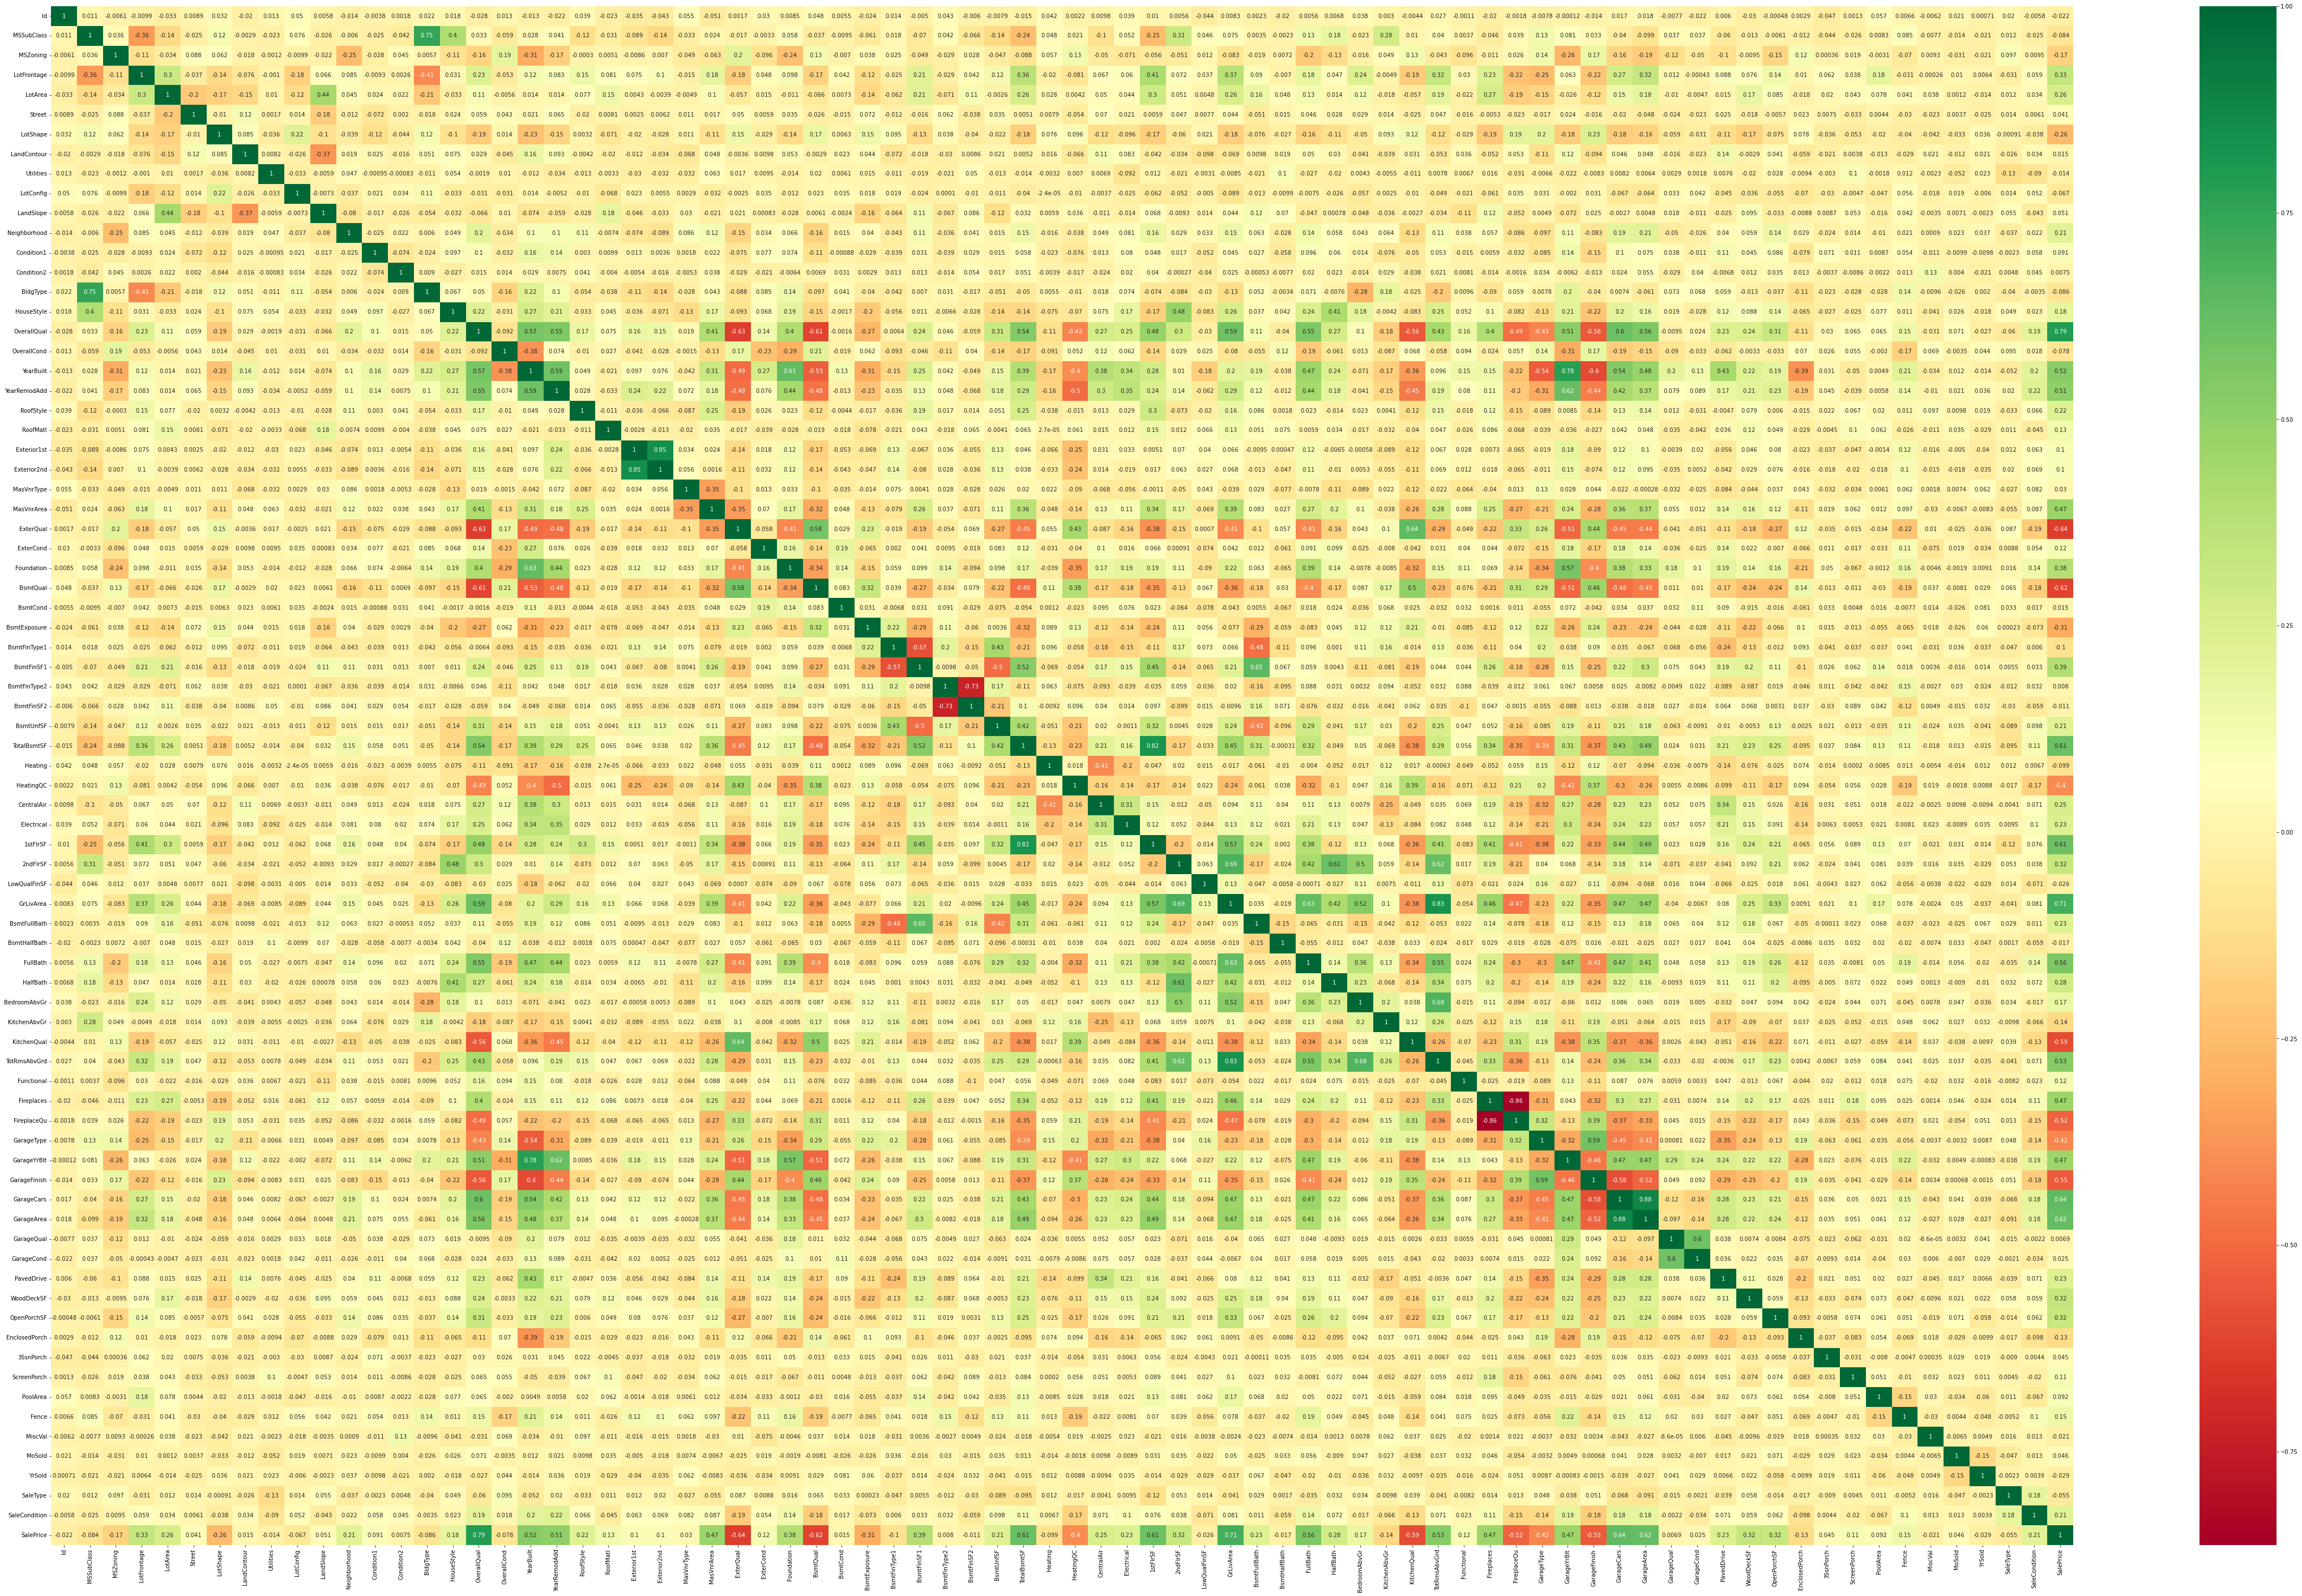

In [32]:
corr = d_train.corr()
plt.figure(figsize=(80,50))
sns.heatmap(corr, annot = True, cmap = 'RdYlGn');

<AxesSubplot:xlabel='SalePrice'>

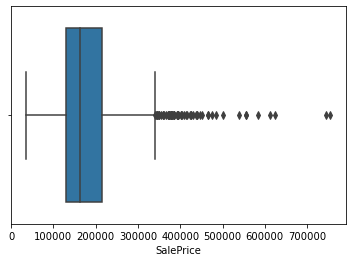

In [33]:
sns.boxplot(x="SalePrice",data=d_train)

In [34]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int32  
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int32  
 6   LotShape       1460 non-null   int32  
 7   LandContour    1460 non-null   int32  
 8   Utilities      1460 non-null   int32  
 9   LotConfig      1460 non-null   int32  
 10  LandSlope      1460 non-null   int32  
 11  Neighborhood   1460 non-null   int32  
 12  Condition1     1460 non-null   int32  
 13  Condition2     1460 non-null   int32  
 14  BldgType       1460 non-null   int32  
 15  HouseStyle     1460 non-null   int32  
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [46]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error,r2_score

In [36]:
features = ["LotFrontage","LotArea","LotShape","Neighborhood","HouseStyle","OverallQual","YearBuilt","YearRemodAdd","RoofStyle","RoofMatl","MasVnrArea","ExterQual","Foundation","BsmtQual","BsmtExposure","BsmtFinType1","BsmtFinSF1","BsmtUnfSF","TotalBsmtSF","HeatingQC","CentralAir","Electrical","1stFlrSF","GrLivArea","BsmtFullBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","KitchenQual","TotRmsAbvGrd","Functional","Fireplaces","FireplaceQu","GarageType","GarageYrBlt","GarageFinish","GarageCars","GarageArea","PavedDrive","WoodDeckSF","OpenPorchSF","EnclosedPorch","SaleCondition"]

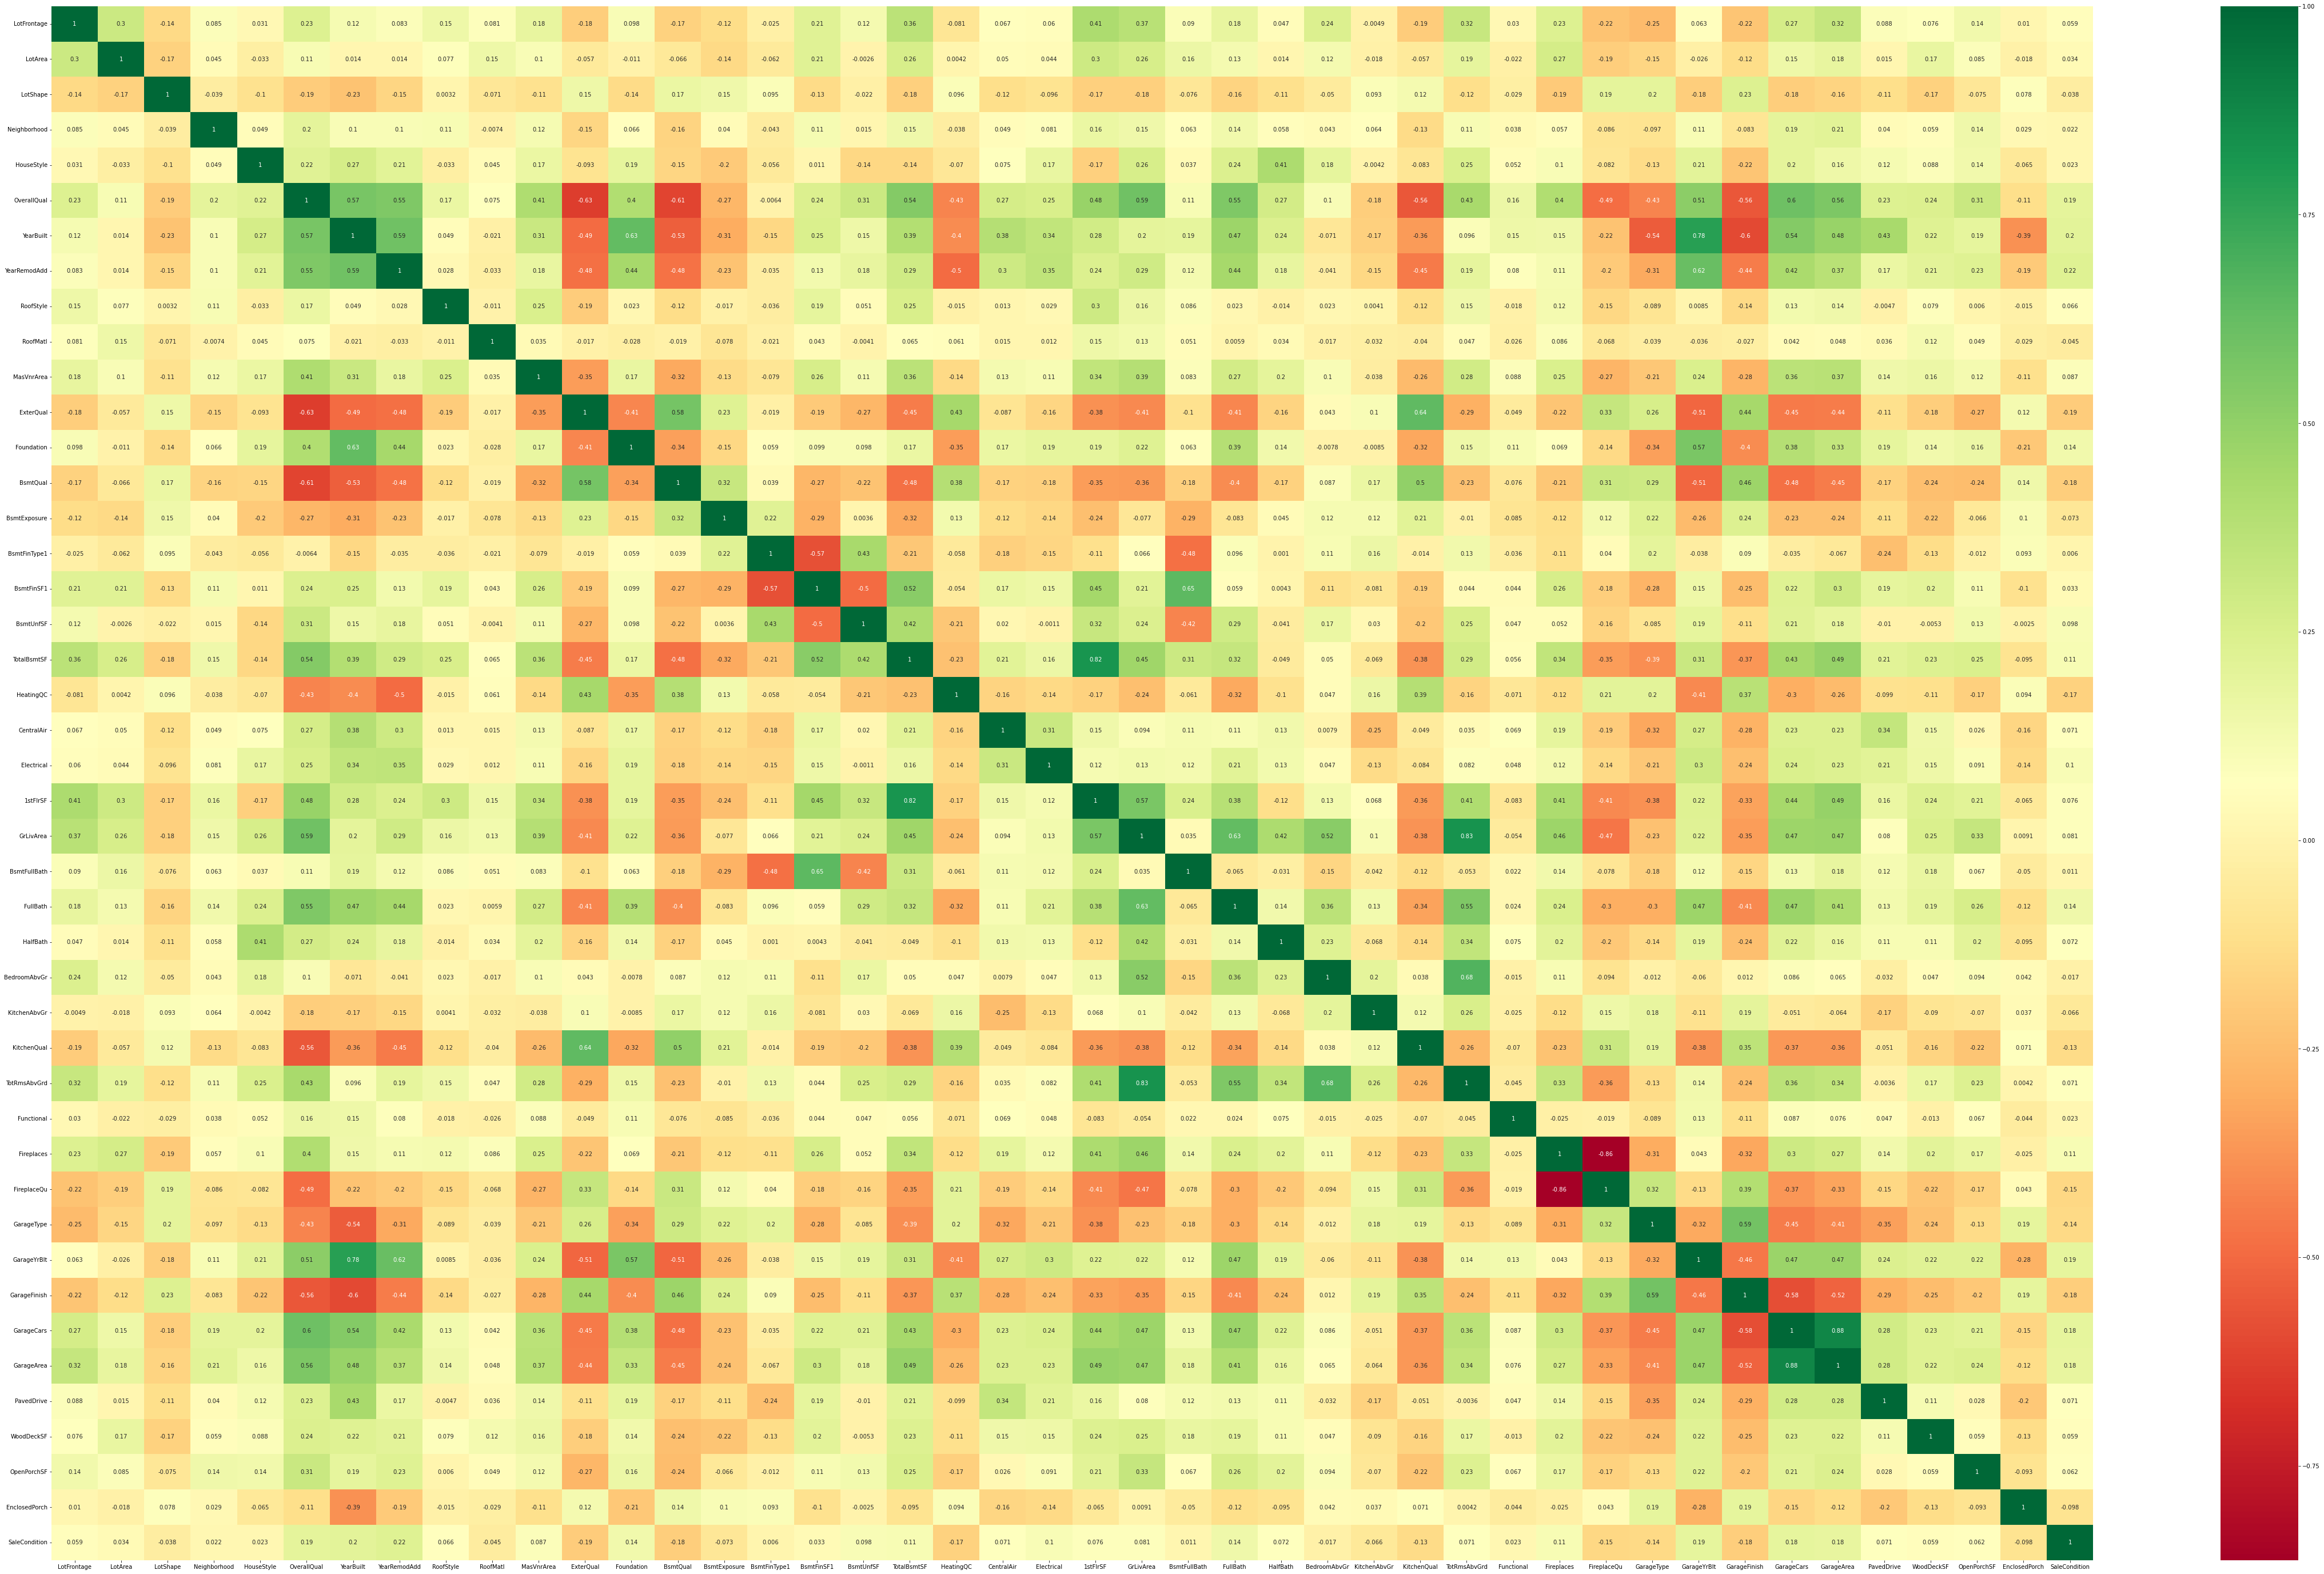

In [37]:
corr = d_train[features].corr()
plt.figure(figsize=(80,50))
sns.heatmap(corr, annot = True, cmap = 'RdYlGn');

In [38]:
d_train[["YearBuilt","GarageYrBlt"]].corr()
## these 2 are highly correlated and out of these 2, YearBuilt is carrying more information when checked for correlation with saleprice
## drop GarageYrBlt
features.remove("GarageYrBlt")

In [39]:
d_train[["1stFlrSF","TotalBsmtSF"]].corr()
d_train[["1stFlrSF","SalePrice"]].corr()
d_train[["TotalBsmtSF","SalePrice"]].corr()
## these 2 are highly correlated and out of these 2, TotalBsmtSF is carrying more information when checked for correlation with saleprice
## drop 1stFlrSF
features.remove("1stFlrSF")

In [40]:
#catg_ft.extend(model_features)
#print(catg_ft)
X_ = d_train[features]
y_ = d_train["SalePrice"]

In [41]:
X_train,X_cv,y_train,y_cv = train_test_split(X_,y_,test_size=0.25,random_state=0)

In [42]:
from sklearn.linear_model import LinearRegression

In [200]:
linear= LinearRegression()
scores = cross_val_score(linear,X_train,y_train,cv=5)
print(scores)
linear_score = scores.mean()
linear=linear.fit(X_train,y_train)
##has bit of variance in score- seems not generalized

[0.87276685 0.74662897 0.90255043 0.85054986 0.86226469]


In [201]:
linear_score

0.8469521614970337

In [191]:
y_pred = linear.predict(X_train)
print(f"mse-{mean_squared_error(y_pred,y_train)}")

mse-830182071.5757763


In [211]:
params = {
    "n_estimators": 6000,
    "max_depth": 4,
    "min_samples_split": 10,
    "learning_rate": 0.005,
    "loss": "squared_error",
}

In [212]:
y_cv.shape

(365,)

In [213]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_cv, reg.predict(X_cv))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 797959028.1415


In [214]:
scores = cross_val_score(reg,X_train,y_train,cv=5)
print(scores)
grdientboost_score = scores.mean()


[0.8709435  0.7164298  0.90747647 0.8628473  0.8968253 ]


In [215]:
grdientboost_score

0.8509044721041775

In [117]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

mse = mean_squared_error(y_cv, reg.predict(X_cv))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 1772405710.4740


In [118]:
scores = cross_val_score(reg,X_train,y_train,cv=5)
tree_score = scores.mean()

In [119]:
tree_score

0.6554117518420968

In [44]:
from xgboost import XGBRegressor

In [53]:
model = XGBRegressor(n_estimators=1500, learning_rate=0.02, max_depth=6, subsample=0.7)
model.fit(X_train, y_train)

C:\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
print("-----")
print("* Training set")
y_pred = model.predict(X_train)
print(f"R2: {r2_score(y_train, y_pred):.2%}")
print(f"RMSE: {mean_squared_log_error(y_train, y_pred, squared=False):.5f}")

print("-----")
print("* Validation set")
y_pred = model.predict(X_cv)
print(f"R2: {r2_score(y_cv, y_pred):.2%}")
print(f"RMSE: {mean_squared_log_error(y_cv, y_pred, squared=False):.5f}")

-----
* Training set
R2: 98.95%
RMSE: 0.05606
-----
* Validation set
R2: 85.34%
RMSE: 0.12471


In [48]:
result = pd.DataFrame()

In [49]:
result["Id"]=d_test["Id"]

In [50]:
result["SalePrice"]=model.predict(d_test[features])

In [51]:
result.isna().sum()

Id           0
SalePrice    0
dtype: int64

In [52]:
result.to_csv("result.csv",index=False)

In [154]:
d_test.shape

(1459, 77)